In [12]:
%matplotlib inline
import CompDoobTransform as cdt
import time
from CompDoobTransform import core
import math
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from CompDoobTransform.utils import normal_logpdf, resampling
from simulator import Simulator
plt.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Computing on ' + str(device))

Computing on cpu


In [13]:
# on veut tester les deux modèles vasicek et CIR en faisant varier l'information apportée par les observations
## ça veut dire en modifiant la densité , on prend des densités de moins en moins informatives sur 
## les observations
# on teste pour une normale une uniforme et une chi2

## on crée le drift et la dérive vasicek
alpha0 = torch.tensor(0.000563, device = device) 
alpha1 = torch.tensor(-0.00673,device=device)
def drift_vasicek(x):
    out = torch.zeros(x.shape)
    out = alpha0 + alpha1 * x
    return(out)

beta0 = torch.tensor(1.66e-05, device = device) 
def sigma_vasicek(x):
    return(beta0)




In [14]:
# on crée les densités conditionnelles des obs par rapport à x

def normal_cond_law(X,N,state_dim,device = device):
    return(
        torch.randn(N,state_dim,device = device)/10000
    )

In [15]:
## on crée les 3 simulateurs 

simul_normal = Simulator(drift= drift_vasicek,
                            sigma= sigma_vasicek,
                            M = 50,#discretisation entre chaque obs nb pas
                            T = torch.tensor(1,device = device),
                            state_dim= 1,
                            var_obs= torch.tensor(0.001,device = device),
                            obs_log_density= lambda x, y: normal_logpdf(y, x, torch.tensor(1,device = device)),
                            X0 = torch.tensor(0.083,device= device),
                            obs_cond_law= normal_cond_law
                            )

In [16]:
## on entraine le modèle de manière standanr i.e avec un contrôle nul
## le filtre n'est alord pas adaptatif
## d'abord on simule du modèle fourni pour avoir les données standardisées
store_state, store_obs = simul_normal.simulate_state_obs(2000,device = device)

c:\Users\aj1ke\Documents\Projets\Sequential_montecarlo\simulator.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stepsize = torch.tensor(self.state["terminal_time"] / self.M, device = device)


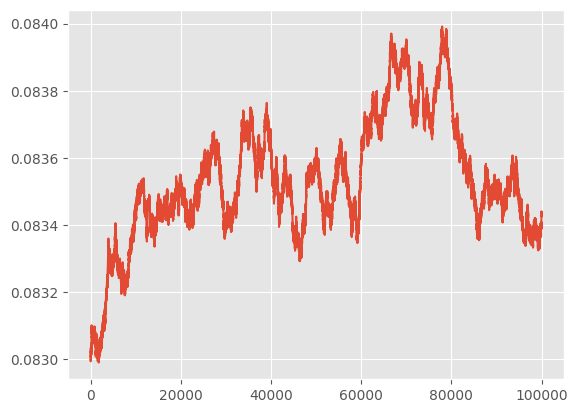

In [17]:
plt.plot(store_obs)
plt.show()

In [18]:
# ensuite on procède à l'entrainement du modèle
simul_normal.train_static()

Optimization iteration: 1 Loss: 0.851066529750824
Optimization iteration: 50 Loss: 0.005837635137140751
Optimization iteration: 100 Loss: 0.0007266065804287791
Optimization iteration: 150 Loss: 0.000668346241582185
Optimization iteration: 200 Loss: 0.00019850987882819027
Optimization iteration: 250 Loss: 0.00019002896442543715
Optimization iteration: 300 Loss: 0.00019146270642522722
Optimization iteration: 350 Loss: 0.0003116595617029816
Optimization iteration: 400 Loss: 0.00013919099001213908
Optimization iteration: 450 Loss: 0.00011997815454378724
Optimization iteration: 500 Loss: 8.582970622228459e-05
Optimization iteration: 550 Loss: 0.00025877077132463455
Optimization iteration: 600 Loss: 0.00010719225974753499
Optimization iteration: 650 Loss: 5.258017699816264e-05
Optimization iteration: 700 Loss: 6.776391091989353e-05
Optimization iteration: 750 Loss: 6.047631541150622e-05
Optimization iteration: 800 Loss: 6.184900121297687e-05
Optimization iteration: 850 Loss: 7.00429736752994

In [19]:
normal_res = simul_normal.compare_apf_bpf(1, [100, 200, 400, 800], [2**6, 2**7, 2**8, 2**9],20)

No. of observations: 100 Repeat: 0
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.8747)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1815.1669)
No. of observations: 100 Repeat: 1
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.5670)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1812.3092)
No. of observations: 100 Repeat: 2
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.7002)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1785.6029)
No. of observations: 100 Repeat: 3
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.2997)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1769.4508)
No. of observations: 100 Repeat: 4
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.5701)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1835.5991)
No. of observations: 100 Repeat: 5
BPF ESS%: tensor(100.)
APFF ESS%: tensor(3.6112)
BPF log-estimate: tensor(-91.8938)
APFF log-estimate: tensor(-1801.1534)
No. of observations: 100 Repeat: 6
BPF ESS%: tensor(100.)


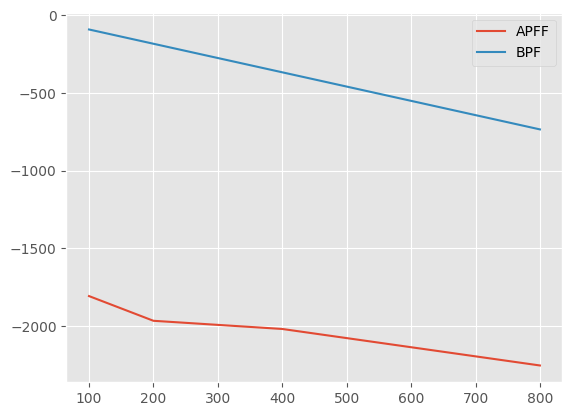

In [24]:
plt.plot([100, 200, 400, 800], normal_res["APFF"]["log_estimate"].mean(1))
plt.plot([100, 200, 400, 800], normal_res["BPF"]["log_estimate"].mean(1))
plt.legend(["APFF","BPF"])